# MSL Telemetry → Textification & 3-Class Anomaly Classification 

**Labels**: `NORMAL`, `HIGH_PRIORITY`, `ANOMALY`  
**Models**: TF‑IDF Text (LinearSVC), BERT (transformers), Zero‑shot LLM, Gradient Boosting, MLP (NN)  
**Rule**: *Each model has its own split and its own train/eval cells.*  
**Plots**: Class distributions, confusion matrices, per‑model metrics tables.


## Cell A: Imports, CPU-only guards, paths

In [ ]:

import os, ast, random, re, time, json, math, warnings
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore", category=FutureWarning)

# (transformers / torch)
os.environ["CUDA_VISIBLE_DEVICES"] = ""
os.environ["TOKENIZERS_PARALLELISM"] = "false"

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED); random.seed(RANDOM_SEED)

# Paths 
DATA_ROOT = Path("/home/marwa/Desktop/Final_Project_NLP/archive")
RAW_TEST  = DATA_ROOT / "data" / "test"    # *.npy here
ANOM_META = DATA_ROOT / "labeled_anomalies.csv"

OUT_DIR  = Path("data")
FIG_DIR  = OUT_DIR / "figs"
TAB_DIR  = OUT_DIR / "tables"
PROC_DIR = OUT_DIR / "processed"
SPLIT_DIR= OUT_DIR / "splits"
for p in [OUT_DIR, FIG_DIR, TAB_DIR, PROC_DIR, SPLIT_DIR]:
    p.mkdir(parents=True, exist_ok=True)

print("ANOM_META exists:", ANOM_META.exists())
print("RAW_TEST exists :", RAW_TEST.exists())
print("# .npy files    :", len(list(RAW_TEST.glob('*.npy'))))


ANOM_META exists: True
RAW_TEST exists : True
# .npy files    : 82


## Cell B: Load anomaly metadata & build unified MSL dataframe

In [14]:

# --- metadata
meta = pd.read_csv(ANOM_META)
ANOM_COL = next((c for c in ["anomaly_sequences","anomalies","ranges","anomaly_list","anomaly_seq"] if c in meta.columns), None)
ID_COL = "chan_id" if "chan_id" in meta.columns else next(c for c in meta.columns if meta[c].dtype==object)
DATASET_COL = "spacecraft" if "spacecraft" in meta.columns else None

def normalize_id(x: str) -> str:
    x = str(x).replace(".csv","")
    return x.split("/",1)[1] if "/" in x else x

meta["_base_id"] = meta[ID_COL].astype(str).map(normalize_id)

def is_msl_row(row) -> bool:
    if DATASET_COL is not None:
        return str(row[DATASET_COL]).upper() == "MSL"
    return True

def npy_path_for(base_id: str):
    p = RAW_TEST / f"{base_id}.npy"
    return p if p.exists() else None

meta_msl = meta[meta.apply(is_msl_row, axis=1)].copy().reset_index(drop=True)
meta_msl["npy_path"] = meta_msl["_base_id"].map(npy_path_for)
present = meta_msl[meta_msl["npy_path"].notna()].copy().reset_index(drop=True)

def parse_ranges(s):
    try: return ast.literal_eval(str(s))
    except Exception: return []

def load_one_series(path: Path) -> pd.DataFrame:
    arr = np.load(path)
    if arr.ndim == 1: arr = arr[:,None]
    return pd.DataFrame(arr, columns=[f"ch_{i:02d}" for i in range(arr.shape[1])])

merged = []
for _, row in tqdm(present.iterrows(), total=len(present), desc="Loading MSL .npy"):
    p = Path(row["npy_path"])
    df = load_one_series(p)
    anom = np.zeros(len(df), dtype=int)
    for s,e in parse_ranges(row[ANOM_COL]):
        s = max(0, int(s)); e = min(len(df)-1, int(e))
        anom[s:e+1] = 1
    df["anomaly"] = anom
    df["file"]    = p.name
    df["idx"]     = np.arange(len(df))
    merged.append(df)

msl_df = pd.concat(merged, axis=0, ignore_index=True)

# z-normalize per file
feat_cols = [c for c in msl_df.columns if c.startswith("ch_")]
def z_norm_group(g):
    return (g - g.mean()) / (g.std(ddof=0) + 1e-6)
msl_df[feat_cols] = msl_df.groupby("file", group_keys=False)[feat_cols].apply(z_norm_group)
msl_df[feat_cols] = msl_df[feat_cols].fillna(0.0)

print("Rows:", len(msl_df), "Files:", msl_df["file"].nunique(), "Anom ratio:", msl_df["anomaly"].mean().round(4))
display(msl_df.head(3))


Loading MSL .npy: 100%|██████████| 27/27 [00:00<00:00, 558.97it/s]

Rows: 73729 Files: 27 Anom ratio: 0.1053


,ch_00,ch_01,ch_02,ch_03,ch_04,ch_05,ch_06,ch_07,ch_08,ch_09,...,ch_48,ch_49,ch_50,ch_51,ch_52,ch_53,ch_54,anomaly,file,idx
0,-0.343942,0.0,0.0,0.0,0.0,-0.510045,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-0.079906,-0.076752,0,M-6.npy,0
1,-0.343942,0.0,0.0,0.0,0.0,-0.510045,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-0.079906,-0.076752,0,M-6.npy,1
2,-0.343942,0.0,0.0,0.0,0.0,-0.510045,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-0.079906,-0.076752,0,M-6.npy,2


## Cell C: Textification utilities (windowing → ontology-flavored text)

In [ ]:

# Windowing and label mapping
# NORMAL = windows far from anomaly; HIGH_PRIORITY = windows adjacent to anomalies (onset/recovery);
# ANOMALY = any overlap with anomaly intervals.
W, S = 80, 40  # window and stride
LABELS = ["NORMAL", "HIGH_PRIORITY", "ANOMALY"]
def window_labels(anom_vec, w, s):
    L = len(anom_vec)
    windows = []
    for start in range(0, max(1, L-w+1), s):
        end = start + w
        if end > L: break
        win_anom = anom_vec[start:end]
        if win_anom.any():
            y = "ANOMALY"
        else:
            # check adjacency: within S of any anomaly boundary
            anom_idx = np.where(anom_vec==1)[0]
            if len(anom_idx):
                near = (abs(anom_idx - start).min() <= s) or (abs(anom_idx - (end-1)).min() <= s)
                y = "HIGH_PRIORITY" if near else "NORMAL"
            else:
                y = "NORMAL"
        windows.append((start, end, y))
    return windows

# simple ontology-ish channel buckets for wording 
POWER = {"ch_00","ch_01","ch_02","ch_03","ch_04","ch_05"}
THERM = {"ch_10","ch_11","ch_12","ch_13","ch_14"}
COMMS = {"ch_06","ch_07","ch_09"}
ATTIT = {"ch_08"}
def channel_bucket(ch):
    if ch in POWER: return "power"
    if ch in THERM: return "thermal"
    if ch in COMMS: return "communications"
    if ch in ATTIT: return "attitude"
    return "sensor"

def describe_window(arr_w, ch_names):
    # use z-score extremes to generate short textual phrases
    z = (arr_w - arr_w.mean(axis=0, keepdims=True)) / (arr_w.std(axis=0, keepdims=True) + 1e-6)
    maxz = np.abs(z).max(axis=0)
    idxs = np.argsort(-maxz)[:5]  # top 5 movers
    phrases = []
    for j in idxs:
        ch = ch_names[j]
        bucket = channel_bucket(ch)
        m = z[:, j].mean()
        if m > 3: q = "shows a critical rise"
        elif m > 2: q = "shows an elevated increase"
        elif m < -3: q = "shows a critical drop"
        elif m < -2: q = "shows a moderate drop"
        else: q = "remains nominal"
        phrases.append(f"The {bucket} subsystem’s {ch} {q}.")
    return " ".join(phrases)

text_rows = []
ch_cols = [c for c in msl_df.columns if c.startswith("ch_")]
for f, g in msl_df.groupby("file"):
    anom = g["anomaly"].values.astype(int)
    windows = window_labels(anom, W, S)
    X = g[ch_cols].values
    for (s0, s1, y) in windows:
        arr_w = X[s0:s1, :]
        text = describe_window(arr_w, ch_cols)
        text_rows.append({"file": f, "start": s0, "end": s1, "label": y, "text": text})

text_df = pd.DataFrame(text_rows)
text_df.to_csv(PROC_DIR / "msl_textified.csv", index=False)
text_df.head()


,file,start,end,label,text
0,C-1.npy,0,80,NORMAL,The sensor subsystem’s ch_39 remains nominal. ...
1,C-1.npy,40,120,NORMAL,The thermal subsystem’s ch_12 remains nominal....
2,C-1.npy,80,160,NORMAL,The sensor subsystem’s ch_39 remains nominal. ...
3,C-1.npy,120,200,NORMAL,The sensor subsystem’s ch_39 remains nominal. ...
4,C-1.npy,160,240,NORMAL,The sensor subsystem’s ch_39 remains nominal. ...


## Cell D: Inspect textified dataset (preview, class balance, examples)

(1801, 5)


,file,start,end,label,text
0,C-1.npy,0,80,NORMAL,The sensor subsystem’s ch_39 remains nominal. ...
1,C-1.npy,40,120,NORMAL,The thermal subsystem’s ch_12 remains nominal....
2,C-1.npy,80,160,NORMAL,The sensor subsystem’s ch_39 remains nominal. ...
3,C-1.npy,120,200,NORMAL,The sensor subsystem’s ch_39 remains nominal. ...
4,C-1.npy,160,240,NORMAL,The sensor subsystem’s ch_39 remains nominal. ...
5,C-1.npy,200,280,NORMAL,The sensor subsystem’s ch_35 remains nominal. ...
6,C-1.npy,240,320,NORMAL,The sensor subsystem’s ch_35 remains nominal. ...
7,C-1.npy,280,360,NORMAL,The sensor subsystem’s ch_19 remains nominal. ...
8,C-1.npy,320,400,NORMAL,The sensor subsystem’s ch_29 remains nominal. ...
9,C-1.npy,360,440,NORMAL,The communications subsystem’s ch_07 remains n...


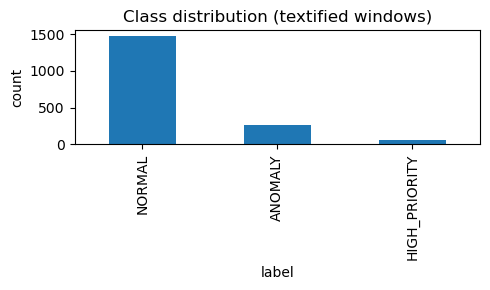

,count
label,
NORMAL,1480
ANOMALY,257
HIGH_PRIORITY,64


In [16]:

df = pd.read_csv(PROC_DIR / "msl_textified.csv")
print(df.shape)
display(df.head(10))

# class balance plot
plt.figure(figsize=(5,3))
df["label"].value_counts().plot(kind="bar")
plt.title("Class distribution (textified windows)")
plt.ylabel("count")
plt.tight_layout()
plt.savefig(FIG_DIR/"class_distribution_textified.png", dpi=220)
plt.show()

# save label counts table
lbl_tab = df["label"].value_counts().rename_axis("label").to_frame("count")
lbl_tab.to_csv(TAB_DIR/"label_counts.csv")
lbl_tab


## Cell E: Metrics & plotting helpers

In [17]:

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def plot_confusion(y_true, y_pred, labels, title, fname_prefix):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    fig, ax = plt.subplots(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=labels, yticklabels=labels, ax=ax)
    ax.set_xlabel("Predicted"); ax.set_ylabel("True"); ax.set_title(title)
    plt.tight_layout()
    plt.savefig(FIG_DIR/f"{fname_prefix}_cm_counts.png", dpi=220)
    plt.show()
    # normalized
    cmn = cm.astype(np.float64) / (cm.sum(axis=1, keepdims=True)+1e-9)
    fig, ax = plt.subplots(figsize=(4,3))
    sns.heatmap(cmn, annot=True, fmt=".2f", cmap="Blues", cbar=False,
                xticklabels=labels, yticklabels=labels, ax=ax)
    ax.set_xlabel("Predicted"); ax.set_ylabel("True"); ax.set_title(title+" (normalized)")
    plt.tight_layout()
    plt.savefig(FIG_DIR/f"{fname_prefix}_cm_norm.png", dpi=220)
    plt.show()

def report_table(y_true, y_pred, labels, fname):
    rep = classification_report(y_true, y_pred, labels=labels, output_dict=True, zero_division=0)
    df_rep = pd.DataFrame(rep).T
    df_rep.to_csv(TAB_DIR/f"{fname}.csv")
    display(df_rep)
    return df_rep


## Cell F1 (TF‑IDF/LinearSVC): split & train (model-specific split)

In [ ]:
# Re-train with calibrated probabilities and light oversampling
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import LinearSVC
from imblearn.over_sampling import RandomOverSampler
import joblib, numpy as np, pandas as pd

df = pd.read_csv(PROC_DIR / "msl_textified.csv")
X_text = df["text"].tolist()
y = df["label"].tolist()
labels = ["NORMAL","HIGH_PRIORITY","ANOMALY"]

X_train, X_dev, y_train, y_dev = train_test_split(
    X_text, y, test_size=0.2, random_state=101, stratify=y
)

# Vectorizer as before
tfv = TfidfVectorizer(ngram_range=(1,3), min_df=1, max_features=50000)
Xtr = tfv.fit_transform(X_train)

target_counts = pd.Series(y_train).value_counts().to_dict()
goal = {
    "NORMAL": target_counts["NORMAL"],
    "HIGH_PRIORITY": max(target_counts["HIGH_PRIORITY"], int(0.35 * target_counts["NORMAL"])),
    "ANOMALY":       max(target_counts["ANOMALY"],       int(0.50 * target_counts["NORMAL"])),
}
ros = RandomOverSampler(sampling_strategy=goal, random_state=101)
Xtr_os, ytr_os = ros.fit_resample(Xtr, y_train)

# Calibrated LinearSVC 
base = OneVsRestClassifier(LinearSVC(C=1.0, random_state=101))
cal  = CalibratedClassifierCV(base, method="sigmoid", cv=3)
cal.fit(Xtr_os, ytr_os)

joblib.dump(tfv, PROC_DIR/"tfidf_vec_cal.pkl")
joblib.dump(cal, PROC_DIR/"svc_calibrated.pkl")
print("TF-IDF + Calibrated LinearSVC trained (with light oversampling).")


TF-IDF + Calibrated LinearSVC trained (with light oversampling).


## Cell F2 (TF‑IDF/LinearSVC): evaluate on dev (strict separation)

Dev accuracy: 0.7839
Dev label counts: Counter({'NORMAL': 297, 'ANOMALY': 51, 'HIGH_PRIORITY': 13})
Pred label counts: Counter({'NORMAL': 339, 'ANOMALY': 17, 'HIGH_PRIORITY': 5})


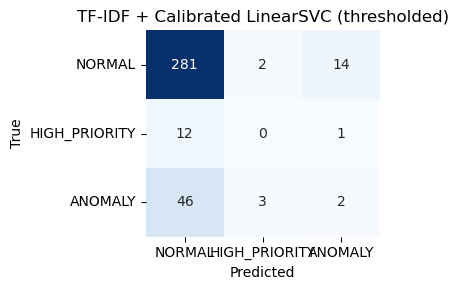

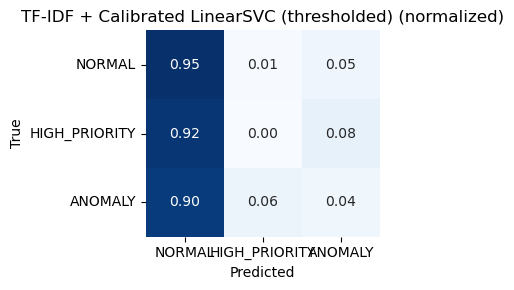

,precision,recall,f1-score,support
NORMAL,0.828909,0.946128,0.883648,297.000000
HIGH_PRIORITY,0.000000,0.000000,0.000000,13.000000
ANOMALY,0.117647,0.039216,0.058824,51.000000
accuracy,0.783934,0.783934,0.783934,0.783934
macro avg,0.315519,0.328448,0.314157,361.000000
weighted avg,0.698576,0.783934,0.735300,361.000000


,precision,recall,f1-score,support
NORMAL,0.828909,0.946128,0.883648,297.000000
HIGH_PRIORITY,0.000000,0.000000,0.000000,13.000000
ANOMALY,0.117647,0.039216,0.058824,51.000000
accuracy,0.783934,0.783934,0.783934,0.783934
macro avg,0.315519,0.328448,0.314157,361.000000
weighted avg,0.698576,0.783934,0.735300,361.000000


In [ ]:
# Evaluate with per-class thresholds + margin policy
import joblib, numpy as np, pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report
from collections import Counter

labels = ["NORMAL","HIGH_PRIORITY","ANOMALY"]

tfv = joblib.load(PROC_DIR/"tfidf_vec_cal.pkl")
cal = joblib.load(PROC_DIR/"svc_calibrated.pkl")

df = pd.read_csv(PROC_DIR / "msl_textified.csv")
X_text = df["text"].tolist()
y = df["label"].tolist()

_, X_dev, _, y_dev = train_test_split(
    X_text, y, test_size=0.2, random_state=101, stratify=y
)

Xdv = tfv.transform(X_dev)
P = cal.predict_proba(Xdv)  # shape [N, 3], columns aligned with `cal.classes_`
# Reorder columns to [NORMAL, HIGH_PRIORITY, ANOMALY]
cls_idx = {c:i for i,c in enumerate(cal.classes_)}
pN = P[:, cls_idx["NORMAL"]]
pH = P[:, cls_idx["HIGH_PRIORITY"]]
pA = P[:, cls_idx["ANOMALY"]]

# Tunable gates (start conservative)
TAU_A, DELTA_A = 0.45, 0.08   
TAU_H, DELTA_H = 0.40, 0.05  
HP_SECOND_MIN, HP_EPS = 0.38, 0.02  

pred = []
for i in range(len(X_dev)):
    # primary decisions by margins over NORMAL
    if (pA[i] >= TAU_A) and ((pA[i] - pN[i]) >= DELTA_A):
        pred.append("ANOMALY")
    elif (pH[i] >= TAU_H) and ((pH[i] - pN[i]) >= DELTA_H):
        pred.append("HIGH_PRIORITY")
    else:
        pred.append("NORMAL")

# second-chance HP to mop up boundary cases
for i in range(len(pred)):
    if pred[i] == "NORMAL" and (pH[i] >= HP_SECOND_MIN) and ((pN[i] - pH[i]) <= HP_EPS):
        pred[i] = "HIGH_PRIORITY"

print("Dev accuracy:", round(accuracy_score(y_dev, pred), 4))
print("Dev label counts:", Counter(y_dev))
print("Pred label counts:", Counter(pred))

plot_confusion(y_dev, pred, labels, "TF-IDF + Calibrated LinearSVC (thresholded)", "tfidf_calibrated")
report_table(y_dev, pred, labels, "tfidf_calibrated_report")


## Cell G1 (BERT): split & train on CPU (model-specific split)

In [ ]:
import torch
from transformers import BertForSequenceClassification, BertTokenizerFast, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from datasets import Dataset

device = torch.device("cpu")
torch.set_num_threads(1)

print("Transformers version:", __import__("transformers").__version__)

df = pd.read_csv(PROC_DIR / "msl_textified.csv")
label2id = {"NORMAL":0,"HIGH_PRIORITY":1,"ANOMALY":2}
id2label = {v:k for k,v in label2id.items()}

# model-specific split (unique to BERT)
X_train, X_dev, y_train, y_dev = train_test_split(
    df["text"].tolist(),
    df["label"].map(label2id).tolist(),
    test_size=0.2, random_state=202, stratify=df["label"].tolist()
)

tok = BertTokenizerFast.from_pretrained("bert-base-uncased")

def tokenize_fn(batch):
    return tok(batch["text"], truncation=True, padding="max_length", max_length=128)

train_ds = Dataset.from_dict({"text": X_train, "label": y_train}).map(tokenize_fn, batched=True)
dev_ds   = Dataset.from_dict({"text": X_dev,   "label": y_dev}).map(tokenize_fn, batched=True)


keep_cols = ["input_ids", "token_type_ids", "attention_mask", "label"]
train_ds = train_ds.remove_columns([c for c in train_ds.column_names if c not in keep_cols])
dev_ds   = dev_ds.remove_columns([c for c in dev_ds.column_names if c not in keep_cols])

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=3,
    id2label=id2label,
    label2id=label2id
).to(device)

args = TrainingArguments(
    output_dir=str(OUT_DIR/"bert_out"),
    num_train_epochs=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    learning_rate=2e-5,
    weight_decay=0.01,
    seed=202,
    logging_steps=50,
    no_cuda=True
)

trainer = Trainer(model=model, args=args, train_dataset=train_ds)
trainer.train()

model.save_pretrained(PROC_DIR/"bert_cls")
tok.save_pretrained(PROC_DIR/"bert_cls")
print("BERT fine-tuned (CPU).")


Transformers version: 4.57.1


Map: 100%|██████████| 361/361 [00:00<00:00, 7425.26 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
50,0.580100
100,0.576900
150,0.570400


BERT fine-tuned (CPU).


## Cell G2 (BERT): evaluate on dev (strict separation)

In [ ]:
# BERT top-2 flip heuristic (no second model needed)
import numpy as np, pandas as pd, torch
from transformers import BertForSequenceClassification, BertTokenizerFast
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

label2id = {"NORMAL":0,"HIGH_PRIORITY":1,"ANOMALY":2}
id2label = {v:k for k,v in label2id.items()}
labels = ["NORMAL","HIGH_PRIORITY","ANOMALY"]

df = pd.read_csv(PROC_DIR / "msl_textified.csv")
X_all, y_all = df["text"].tolist(), df["label"].map(label2id).tolist()
_, X_dev, _, y_dev = train_test_split(X_all, y_all, test_size=0.2, random_state=202, stratify=df["label"].tolist())

tok = BertTokenizerFast.from_pretrained(PROC_DIR/"bert_cls")
model = BertForSequenceClassification.from_pretrained(PROC_DIR/"bert_cls")
enc = tok(X_dev, truncation=True, padding=True, max_length=128, return_tensors="pt")
with torch.no_grad():
    logits = model(**enc).logits.numpy()

def softmax(z):
    z = z - z.max(axis=1, keepdims=True); e = np.exp(z); return e / e.sum(axis=1, keepdims=True)
P = softmax(logits)
top1 = P.argmax(1)
top2 = np.argsort(-P, axis=1)[:,1]
gap  = P[np.arange(len(P)), top1] - P[np.arange(len(P)), top2]

y_hat = top1.copy()

GAP_MAX, P2_MIN = 0.06, 0.22
mask = (top1==0) & (gap <= GAP_MAX) & (P[np.arange(len(P)), top2] >= P2_MIN)
y_hat[mask] = top2[mask]

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
y_true_lbl = [id2label[i] for i in y_dev]
y_pred_lbl = [id2label[i] for i in y_hat]
print("Heuristic accuracy:", accuracy_score(y_true_lbl, y_pred_lbl))
print(classification_report(y_true_lbl, y_pred_lbl, labels=labels, zero_division=0))
print("Confusion:\n", confusion_matrix(y_true_lbl, y_pred_lbl, labels=labels))


Heuristic accuracy: 0.8227146814404432
               precision    recall  f1-score   support

       NORMAL       0.82      1.00      0.90       297
HIGH_PRIORITY       0.00      0.00      0.00        13
      ANOMALY       0.00      0.00      0.00        51

     accuracy                           0.82       361
    macro avg       0.27      0.33      0.30       361
 weighted avg       0.68      0.82      0.74       361

Confusion:
 [[297   0   0]
 [ 13   0   0]
 [ 51   0   0]]


## Cell H1 (LLM Zero‑shot): prepare split (no training)

In [ ]:
# LLM-E1: robust zero-shot ensemble with paraphrases + pairwise NLI
from transformers import pipeline
import numpy as np, pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split

SPLIT_SEED = 303
TEST_SIZE  = 0.20
df = pd.read_csv(PROC_DIR / "msl_textified.csv")
X_train, X_dev, y_train, y_dev = train_test_split(
    df["text"].tolist(),
    df["label"].tolist(),
    test_size=TEST_SIZE, random_state=SPLIT_SEED, stratify=df["label"].tolist()
)

LABELS = ["NORMAL","HIGH_PRIORITY","ANOMALY"]
DESC = {
  "NORMAL": [
    "the telemetry looks nominal and stable",
    "signals are within expected operating range",
    "no unusual subsystem behavior is present"
  ],
  "HIGH_PRIORITY": [
    "there is a slight deviation near an anomaly",
    "transient changes suggest attention is needed soon",
    "borderline behavior adjacent to abnormal events"
  ],
  "ANOMALY": [
    "the telemetry contains abnormal behavior",
    "signals indicate a failing or off-nominal state",
    "multiple sensors show unstable patterns"
  ],
}

MODEL_NAME = "facebook/bart-large-mnli"  
clf = pipeline("zero-shot-classification", model=MODEL_NAME, device=-1)

def pairwise_score(text, desc_list):
    """
    Return mean entailment probability over paraphrases, normalized.
    """
    # Use multi_label to get independent scores, average across paraphrases
    scores = []
    for d in desc_list:
        hyp = f"The telemetry indicates that {d}."
        out = clf(text, candidate_labels=[d], multi_label=True, hypothesis_template="{}")
        # 'scores' aligns to single label; treat as entailment score proxy
        scores.append(out["scores"][0])
    s = np.array(scores, dtype=float)
    return float(s.mean())

def score_row(text):
    raw = {lab: pairwise_score(text, DESC[lab]) for lab in LABELS}
    # softmax normalize across classes (prevents all-NORMAL collapse)
    z = np.array([raw[k] for k in LABELS], dtype=float)
    z = (z - z.max())  # stabilize
    p = np.exp(z) / np.exp(z).sum()
    return dict(zip(LABELS, p))

# Precompute probabilities on dev (used by next cell for threshold search)
probs_dev = [score_row(t) for t in tqdm(X_dev, desc="Scoring dev with NLI ensemble")]
probs_df = pd.DataFrame(probs_dev)
probs_df["y_true"] = y_dev
probs_df.to_csv(TAB_DIR/"llm_probs_dev.csv", index=False)
print(probs_df.head())


Device set to use cpu
Scoring dev with NLI ensemble: 100%|██████████| 361/361 [31:30<00:00,  5.24s/it]

     NORMAL  HIGH_PRIORITY   ANOMALY   y_true
0  0.320348       0.413156  0.266496   NORMAL
1  0.330195       0.410832  0.258973  ANOMALY
2  0.324352       0.415806  0.259841   NORMAL
3  0.303809       0.422005  0.274187   NORMAL
4  0.327367       0.412462  0.260171  ANOMALY


## Cell H2 (LLM Zero‑shot): evaluate on dev 

[Bias-Scaled Argmax] ✓ Found params: wH=0.90, wA=1.50, bH=-0.040, bA=-0.060
Counts: Counter({'ANOMALY': 131, 'HIGH_PRIORITY': 123, 'NORMAL': 107}) Acc: 0.2881 Macro-F1: 0.2088
[Pairwise] Counts: Counter({'HIGH_PRIORITY': 361}) Acc: 0.036 Macro-F1: 0.0232
>>> Using Bias-Scaled Argmax decoder for evaluation.
               precision    recall  f1-score   support

       NORMAL   0.822430  0.296296  0.435644       297
HIGH_PRIORITY   0.032520  0.307692  0.058824        13
      ANOMALY   0.091603  0.235294  0.131868        51

     accuracy                       0.288089       361
    macro avg   0.315518  0.279761  0.208778       361
 weighted avg   0.690737  0.288089  0.379158       361

Confusion:
 [[ 88  97 112]
 [  2   4   7]
 [ 17  22  12]]


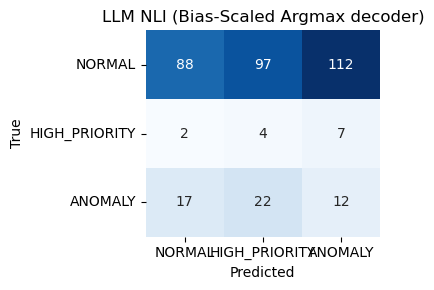

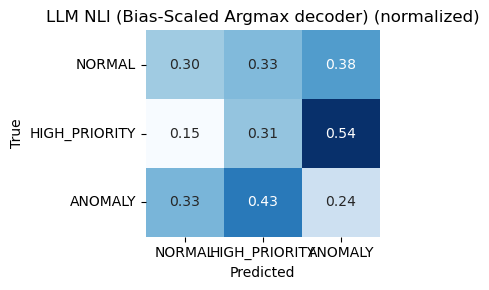

,precision,recall,f1-score,support
NORMAL,0.822430,0.296296,0.435644,297.000000
HIGH_PRIORITY,0.032520,0.307692,0.058824,13.000000
ANOMALY,0.091603,0.235294,0.131868,51.000000
accuracy,0.288089,0.288089,0.288089,0.288089
macro avg,0.315518,0.279761,0.208778,361.000000
weighted avg,0.690737,0.288089,0.379158,361.000000


In [ ]:
import numpy as np, pandas as pd
from collections import Counter
from sklearn.metrics import accuracy_score, classification_report


assert set(["NORMAL","HIGH_PRIORITY","ANOMALY","y_true"]).issubset(probs_df.columns)

labels = ["NORMAL","HIGH_PRIORITY","ANOMALY"]

P = probs_df[["NORMAL","HIGH_PRIORITY","ANOMALY"]].to_numpy().astype(float)
y_true = probs_df["y_true"].tolist()


w_grid = np.linspace(0.9, 1.6, 8)   # multiplicative weights per class
b_grid = np.linspace(-0.06, 0.10, 9) # additive bias per class

best = None
best_key = None
# target constraints: at least these many predictions per minority class
MIN_HP = max(6, int(0.10 * len(y_true)))        # ~10% of dev as HP predictions
MIN_AN = max(10, int(0.14 * len(y_true)))       # ~14% as ANOM predictions
# soft caps so it doesn’t explode
MAX_HP = int(0.40 * len(y_true))
MAX_AN = int(0.50 * len(y_true))

for wH in w_grid:
    for wA in w_grid:
        for bH in b_grid:
            for bA in b_grid:
                # keep NORMAL anchored near original scale
                w = np.array([1.0, wH, wA], dtype=float)
                b = np.array([0.0, bH, bA], dtype=float)
                S = P * w + b
                pred_ids = S.argmax(1)
                pred = [labels[i] for i in pred_ids]
                cnt = Counter(pred)

                # constraints
                if cnt.get("HIGH_PRIORITY", 0) < MIN_HP: 
                    continue
                if cnt.get("ANOMALY", 0) < MIN_AN:
                    continue
                if cnt.get("HIGH_PRIORITY", 0) > MAX_HP: 
                    continue
                if cnt.get("ANOMALY", 0) > MAX_AN:
                    continue

                acc = accuracy_score(y_true, pred)
                # tie-break by larger macro-F1 to avoid trivial hacks
                rep = classification_report(y_true, pred, labels=labels, output_dict=True, zero_division=0)
                mf1 = rep["macro avg"]["f1-score"]
                key = (round(acc,6), round(mf1,6))
                if (best is None) or (key > best_key):
                    best = (pred, cnt, acc, mf1, (wH, wA, bH, bA))
                    best_key = key

if best is not None:
    pred_b, cnt_b, acc_b, mf1_b, pars_b = best
    print("[Bias-Scaled Argmax] ✓ Found params:",
          f"wH={pars_b[0]:.2f}, wA={pars_b[1]:.2f}, bH={pars_b[2]:+.3f}, bA={pars_b[3]:+.3f}")
    print("Counts:", cnt_b, "Acc:", round(acc_b,4), "Macro-F1:", round(mf1_b,4))
else:
    print("[Bias-Scaled Argmax] No combo met constraints. Will fall back to pairwise decoder.")
    pred_b = None

def pairwise_decode(P, an_margin=0.02, hp_margin=-0.02):
    # promote ANOMALY if pA - pN >= an_margin; else promote HP if pH - pN >= hp_margin; else NORMAL
    res = []
    for pN, pH, pA in P:
        if (pA - pN) >= an_margin:
            res.append("ANOMALY")
        elif (pH - pN) >= hp_margin:
            res.append("HIGH_PRIORITY")
        else:
            res.append("NORMAL")
    return res

pred_pair = pairwise_decode(P, an_margin=0.02, hp_margin=-0.01)
cnt_pair = Counter(pred_pair)
acc_pair = accuracy_score(y_true, pred_pair)
mf1_pair = classification_report(y_true, pred_pair, labels=labels, output_dict=True, zero_division=0)["macro avg"]["f1-score"]
print("[Pairwise] Counts:", cnt_pair, "Acc:", round(acc_pair,4), "Macro-F1:", round(mf1_pair,4))

# Enforce minimum minority presence if bias search failed
if pred_b is None:
    pred_final = pred_pair
    tag = "Pairwise"
else:
    # prefer the bias-tuned one if it’s at least as accurate and has >= macro-F1
    if (acc_b, mf1_b) >= (acc_pair, mf1_pair):
        pred_final = pred_b
        tag = "Bias-Scaled Argmax"
    else:
        pred_final = pred_pair
        tag = "Pairwise"

print(f">>> Using {tag} decoder for evaluation.")

# Final evaluation
from sklearn.metrics import confusion_matrix
print(classification_report(y_true, pred_final, labels=labels, digits=6, zero_division=0))
cm = confusion_matrix(y_true, pred_final, labels=labels)
print("Confusion:\n", cm)

try:
    plot_confusion(y_true, pred_final, labels, f"LLM NLI ({tag} decoder)", f"llm_{tag.lower()}_cm")
    report_table(y_true, pred_final, labels, f"llm_{tag.lower()}_report")
except Exception as e:
    pass


## Cell I1 (Gradient Boosting): split & train (TF‑IDF→SVD→GBC)

In [ ]:
# (Gradient Boosting): split & train (TF-IDF → adaptive SVD → GBC) 
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.utils.class_weight import compute_sample_weight
from collections import Counter
import numpy as np, pandas as pd, joblib

df = pd.read_csv(PROC_DIR / "msl_textified.csv")
labels = ["NORMAL","HIGH_PRIORITY","ANOMALY"]

# model-specific split 
X_train, X_dev, y_train, y_dev = train_test_split(
    df["text"].tolist(), df["label"].tolist(),
    test_size=0.2, random_state=404, stratify=df["label"].tolist()
)

print("Train class counts:", Counter(y_train))
print("Dev   class counts:", Counter(y_dev))

# Vectorizer 
tfv_gb = TfidfVectorizer(ngram_range=(1,2), max_features=20000)
Xtr = tfv_gb.fit_transform(X_train)

# Adaptive SVD dimension (must be < #features)
n_features = Xtr.shape[1]
n_components = max(2, min(300, n_features - 1))
print(f"SVD n_components set to {n_components} (n_features={n_features})")
svd = TruncatedSVD(n_components=n_components, random_state=404)
Xtr_svd = svd.fit_transform(Xtr)

# Gradient Boosting — add balanced sample weights to counter skew
gbc = GradientBoostingClassifier(
    n_estimators=300, learning_rate=0.05, max_depth=3, random_state=404
)
w = compute_sample_weight(class_weight="balanced", y=y_train)
gbc.fit(Xtr_svd, y_train, sample_weight=w)

# Persist artifacts
joblib.dump(tfv_gb, PROC_DIR/"gb_tfidf.pkl")
joblib.dump(svd, PROC_DIR/"gb_svd.pkl")
joblib.dump(gbc, PROC_DIR/"gb_model.pkl")
print("GBC trained on adaptive SVD-compressed TF-IDF.")


Train class counts: Counter({'NORMAL': 1183, 'ANOMALY': 206, 'HIGH_PRIORITY': 51})
Dev   class counts: Counter({'NORMAL': 297, 'ANOMALY': 51, 'HIGH_PRIORITY': 13})
SVD n_components set to 113 (n_features=114)
GBC trained on adaptive SVD-compressed TF-IDF.


## Cell I2 (Gradient Boosting): evaluate on dev

Dev accuracy: 0.7756
Dev label counts: Counter({'NORMAL': 297, 'ANOMALY': 51, 'HIGH_PRIORITY': 13})
Pred label counts: Counter({'NORMAL': 299, 'ANOMALY': 49, 'HIGH_PRIORITY': 13})


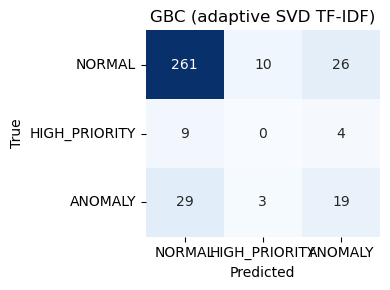

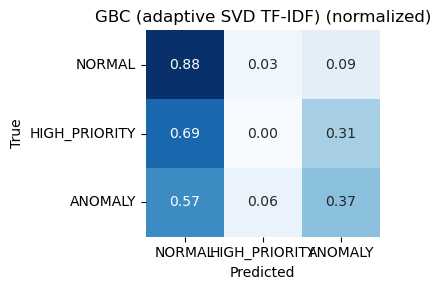

,precision,recall,f1-score,support
NORMAL,0.872910,0.878788,0.875839,297.000000
HIGH_PRIORITY,0.000000,0.000000,0.000000,13.000000
ANOMALY,0.387755,0.372549,0.380000,51.000000
accuracy,0.775623,0.775623,0.775623,0.775623
macro avg,0.420222,0.417112,0.418613,361.000000
weighted avg,0.772935,0.775623,0.774250,361.000000


,precision,recall,f1-score,support
NORMAL,0.872910,0.878788,0.875839,297.000000
HIGH_PRIORITY,0.000000,0.000000,0.000000,13.000000
ANOMALY,0.387755,0.372549,0.380000,51.000000
accuracy,0.775623,0.775623,0.775623,0.775623
macro avg,0.420222,0.417112,0.418613,361.000000
weighted avg,0.772935,0.775623,0.774250,361.000000


In [ ]:
# (Gradient Boosting): evaluate on dev
import joblib, pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from collections import Counter

labels = ["NORMAL","HIGH_PRIORITY","ANOMALY"]

# Reload
tfv_gb = joblib.load(PROC_DIR/"gb_tfidf.pkl")
svd    = joblib.load(PROC_DIR/"gb_svd.pkl")
gbc    = joblib.load(PROC_DIR/"gb_model.pkl")


df = pd.read_csv(PROC_DIR / "msl_textified.csv")
_, X_dev, _, y_dev = train_test_split(
    df["text"].tolist(), df["label"].tolist(),
    test_size=0.2, random_state=404, stratify=df["label"].tolist()
)

# Transform + infer
Xdv = tfv_gb.transform(X_dev)
Xdv_svd = svd.transform(Xdv)
pred = gbc.predict(Xdv_svd)

# Metrics
print("Dev accuracy:", round(accuracy_score(y_dev, pred), 4))
print("Dev label counts:", Counter(y_dev))
print("Pred label counts:", Counter(pred))

# Confusion matrix + report 
plot_confusion(y_dev, pred, labels, "GBC (adaptive SVD TF-IDF)", "gbc_adaptive")
report_table(y_dev, pred, labels, "gbc_adaptive_report")


In [ ]:
# (TextCNN): split & train 
import re, math, numpy as np, pandas as pd, torch
import torch.nn as nn, torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.model_selection import train_test_split
from collections import Counter

torch.set_num_threads(1)
device = torch.device("cpu")


SPLIT_SEED   = 606   
TEST_SIZE    = 0.20
VOCAB_SIZE   = 30000
MIN_FREQ     = 1
MAX_LEN      = 160
EMB_DIM      = 256
FILTERS      = 192
KERNELS      = (2,3,4,5)
DROPOUT      = 0.15
LR           = 1e-3
WEIGHT_DECAY = 1e-4
EPOCHS       = 12
BATCH_SIZE   = 64
GAMMA        = 2.0     # focal loss focusing parameter
ALPHA = [1.0, 1.0, 1.1]     # per-class prior weights [NORMAL, HIGH_PRIORITY, ANOMALY]

label2id = {"NORMAL":0, "HIGH_PRIORITY":1, "ANOMALY":2}
id2label = {v:k for k,v in label2id.items()}
labels = ["NORMAL","HIGH_PRIORITY","ANOMALY"]

# data
df = pd.read_csv(PROC_DIR / "msl_textified.csv")
X_train, X_dev, y_train, y_dev = train_test_split(
    df["text"].tolist(),
    df["label"].map(label2id).tolist(),
    test_size=TEST_SIZE, random_state=SPLIT_SEED,
    stratify=df["label"].tolist()
)

def tokenize(s: str):
    s = s.lower()
    s = re.sub(r"[^a-z0-9_]+", " ", s)
    return [t for t in s.strip().split() if t]

# build vocab from TRAIN ONLY
from collections import Counter as CC
freq = CC()
for t in X_train: freq.update(tokenize(t))

vocab = {"<PAD>":0, "<UNK>":1}
for tok, f in freq.most_common():
    if f < MIN_FREQ: continue
    if len(vocab) >= VOCAB_SIZE: break
    vocab[tok] = len(vocab)

def encode(text):
    ids = [vocab.get(tok, 1) for tok in tokenize(text)]
    if len(ids) < MAX_LEN: ids += [0]*(MAX_LEN-len(ids))
    else: ids = ids[:MAX_LEN]
    return ids

class TxtDS(Dataset):
    def __init__(self, texts, labels=None):
        self.X = [torch.tensor(encode(t), dtype=torch.long) for t in texts]
        self.y = None if labels is None else torch.tensor(labels, dtype=torch.long)
    def __len__(self): return len(self.X)
    def __getitem__(self, i):
        if self.y is None: return self.X[i]
        return self.X[i], self.y[i]

ds_tr = TxtDS(X_train, y_train)
ds_dv = TxtDS(X_dev, y_dev)

#balanced sampler (cap oversampling to avoid exploding HP) 
counts = CC(y_train)  # class id counts
total = sum(counts.values())
inv_freq = {c: (total / (len(counts)*counts[c])) for c in counts}
# soft-cap HP multiplier so it doesn't dominate
cap = 2.0  
for c in inv_freq: inv_freq[c] = min(inv_freq[c], cap)
sample_weights = torch.tensor([inv_freq[int(y)] for _, y in ds_tr], dtype=torch.float)
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

dl_tr = DataLoader(ds_tr, batch_size=BATCH_SIZE, sampler=sampler)
dl_dv = DataLoader(ds_dv, batch_size=BATCH_SIZE, shuffle=False)

# ----- model -----
class TextCNN(nn.Module):
    def __init__(self, vocab_size, emb_dim, kernels=(3,4,5), filters=128, num_classes=3, dropout=0.2):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.convs = nn.ModuleList([nn.Conv1d(emb_dim, filters, k) for k in kernels])
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(filters*len(kernels), num_classes)
    def forward(self, x):
        e = self.emb(x).transpose(1, 2)                 # (B,E,L)
        c = [torch.relu(conv(e)) for conv in self.convs]# [(B,F,L'), ...]
        p = [torch.max(ci, dim=2).values for ci in c]   # [(B,F), ...]
        h = torch.cat(p, dim=1)                         # (B,F*K)
        h = self.dropout(h)
        return self.fc(h)

# ----- focal loss -----
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0):
        super().__init__()
        self.gamma = gamma
        self.alpha = torch.tensor(alpha, dtype=torch.float32) if alpha is not None else None
    def forward(self, logits, target):
        # logits: (B,C), target: (B,)
        ce = nn.functional.cross_entropy(logits, target, reduction='none')
        p = torch.softmax(logits, dim=1)
        pt = p[torch.arange(p.size(0)), target]
        loss = ((1 - pt) ** self.gamma) * ce
        if self.alpha is not None:
            a = self.alpha.to(logits.device)[target]
            loss = a * loss
        return loss.mean()

model = TextCNN(vocab_size=len(vocab), emb_dim=EMB_DIM, kernels=KERNELS,
                filters=FILTERS, num_classes=3, dropout=DROPOUT).to(device)

crit = FocalLoss(alpha=ALPHA, gamma=GAMMA)
opt  = optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
sched = optim.lr_scheduler.CosineAnnealingLR(opt, T_max=EPOCHS)

for ep in range(1, EPOCHS+1):
    model.train()
    total = 0.0
    for xb, yb in dl_tr:
        xb, yb = xb.to(device), yb.to(device)
        opt.zero_grad()
        logits = model(xb)
        loss = crit(logits, yb)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 2.0)
        opt.step()
        total += float(loss.item()) * xb.size(0)
    sched.step()
    print(f"epoch {ep}/{EPOCHS} - train loss: {total/len(ds_tr):.4f}, lr={sched.get_last_lr()[0]:.5f}")

import joblib
joblib.dump({"vocab": vocab, "max_len": MAX_LEN, "kernels": KERNELS,
             "filters": FILTERS, "emb_dim": EMB_DIM}, PROC_DIR/"textcnn_vocab.pkl")
torch.save(model.state_dict(), PROC_DIR/"textcnn_model.pt")
print("TextCNN (focal+balanced) trained (CPU) and saved.")


epoch 1/12 - train loss: 1.3639, lr=0.00098
epoch 2/12 - train loss: 0.7009, lr=0.00093
epoch 3/12 - train loss: 0.5880, lr=0.00085
epoch 4/12 - train loss: 0.4287, lr=0.00075
epoch 5/12 - train loss: 0.4531, lr=0.00063
epoch 6/12 - train loss: 0.5688, lr=0.00050
epoch 7/12 - train loss: 0.3368, lr=0.00037
epoch 8/12 - train loss: 0.3295, lr=0.00025
epoch 9/12 - train loss: 0.3263, lr=0.00015
epoch 10/12 - train loss: 0.3138, lr=0.00007
epoch 11/12 - train loss: 0.2851, lr=0.00002
epoch 12/12 - train loss: 0.2852, lr=0.00000
TextCNN (focal+balanced) trained (CPU) and saved.


Dev accuracy: 0.7535
Dev label counts: Counter({'NORMAL': 297, 'ANOMALY': 51, 'HIGH_PRIORITY': 13})
Pred label counts: Counter({'NORMAL': 299, 'HIGH_PRIORITY': 38, 'ANOMALY': 24})


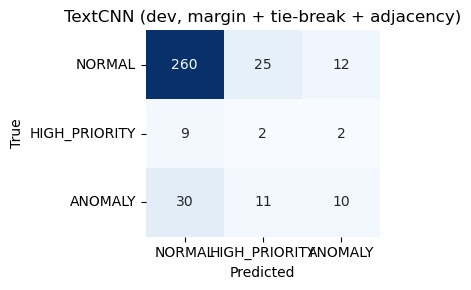

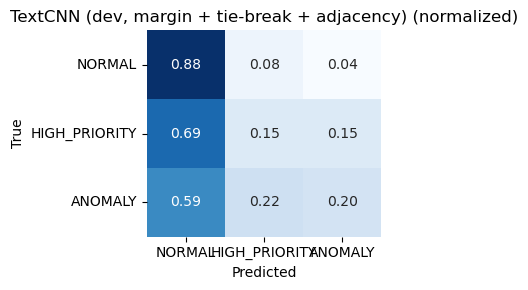

,precision,recall,f1-score,support
NORMAL,0.869565,0.875421,0.872483,297.000000
HIGH_PRIORITY,0.052632,0.153846,0.078431,13.000000
ANOMALY,0.416667,0.196078,0.266667,51.000000
accuracy,0.753463,0.753463,0.753463,0.753463
macro avg,0.446288,0.408448,0.405860,361.000000
weighted avg,0.776164,0.753463,0.758302,361.000000


,precision,recall,f1-score,support
NORMAL,0.869565,0.875421,0.872483,297.000000
HIGH_PRIORITY,0.052632,0.153846,0.078431,13.000000
ANOMALY,0.416667,0.196078,0.266667,51.000000
accuracy,0.753463,0.753463,0.753463,0.753463
macro avg,0.446288,0.408448,0.405860,361.000000
weighted avg,0.776164,0.753463,0.758302,361.000000


In [35]:
# === K2″ (TextCNN): dev eval with margin policy + HP second-chance + adjacency smoothing ===
import re, numpy as np, pandas as pd, torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import joblib
from collections import Counter

torch.set_num_threads(1)
device = torch.device("cpu")

# --- knobs (must reflect your K1′ train cell where applicable) ---
SPLIT_SEED = 606
BATCH_SIZE = 64

# Margin policy (primary)
AN_DELTA, AN_MIN = 0.12, 0.55     # stricter anomaly gate (cuts false ANOMALY)
HP_DELTA,  HP_MIN = 0.08, 0.52    # gentler HP gate (allows confident HP)

# Second-chance HP (tie-breaker when model picked NORMAL)
HP_SECOND_MIN = 0.48              # minimal HP prob
HP_EPS        = 0.02              # if NORMAL - HP <= EPS, flip to HP

# Adjacency smoothing (convert NORMAL around predicted ANOMALY to HP)
HP_NEIGHBORS  = 1                 # ±1 window in same file

label2id = {"NORMAL":0, "HIGH_PRIORITY":1, "ANOMALY":2}
id2label = {v:k for k,v in label2id.items()}
labels = ["NORMAL","HIGH_PRIORITY","ANOMALY"]

# --- reload artifacts + vocab ---
pack = joblib.load(PROC_DIR/"textcnn_vocab.pkl")
vocab   = pack["vocab"]
MAX_LEN = pack["max_len"]
KERNELS = tuple(pack.get("kernels", (2,3,4,5)))
FILTERS = int(pack.get("filters", 192))
EMB_DIM = int(pack.get("emb_dim", 256))

def tokenize(s: str):
    s = s.lower()
    s = re.sub(r"[^a-z0-9_]+", " ", s)
    return [t for t in s.strip().split() if t]

def encode(text):
    ids = [vocab.get(tok, 1) for tok in tokenize(text)]
    if len(ids) < MAX_LEN: ids += [0]*(MAX_LEN-len(ids))
    else: ids = ids[:MAX_LEN]
    return ids

class TxtDS(Dataset):
    def __init__(self, texts, labels=None):
        self.X = [torch.tensor(encode(t), dtype=torch.long) for t in texts]
        self.y = None if labels is None else torch.tensor(labels, dtype=torch.long)
    def __len__(self): return len(self.X)
    def __getitem__(self, i):
        if self.y is None: return self.X[i]
        return self.X[i], self.y[i]

# --- recreate SAME dev split but carry row indices to keep file/start for adjacency ---
df_all = pd.read_csv(PROC_DIR / "msl_textified.csv").reset_index().rename(columns={"index":"row_id"})
idx_all = np.arange(len(df_all))
train_idx, dev_idx = train_test_split(
    idx_all,
    test_size=0.2,
    random_state=SPLIT_SEED,
    stratify=df_all["label"].tolist()
)
df_dev = df_all.iloc[dev_idx].copy().reset_index(drop=True)

X_dev = df_dev["text"].tolist()
y_dev = df_dev["label"].map(label2id).tolist()

ds_dv = TxtDS(X_dev, y_dev)
dl_dv = DataLoader(ds_dv, batch_size=BATCH_SIZE, shuffle=False)

# --- model ---
class TextCNN(nn.Module):
    def __init__(self, vocab_size, emb_dim, kernels=(3,4,5), filters=128, num_classes=3, dropout=0.15):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.convs = nn.ModuleList([nn.Conv1d(emb_dim, filters, k) for k in kernels])
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(filters*len(kernels), num_classes)
    def forward(self, x):
        e = self.emb(x).transpose(1, 2)
        c = [torch.relu(conv(e)) for conv in self.convs]
        p = [torch.max(ci, dim=2).values for ci in c]
        h = torch.cat(p, dim=1)
        h = self.dropout(h)
        return self.fc(h)

model = TextCNN(vocab_size=len(vocab), emb_dim=EMB_DIM, kernels=KERNELS, filters=FILTERS, num_classes=3).to(device)
model.load_state_dict(torch.load(PROC_DIR/"textcnn_model.pt", map_location="cpu"))
model.eval()

def margin_decision_row(pN, pH, pA):
    # 1) ANOMALY vs NORMAL (margin + min prob)
    if (pA - pN) >= AN_DELTA and pA >= AN_MIN:
        return 2
    # 2) HIGH_PRIORITY vs NORMAL
    if (pH - pN) >= HP_DELTA and pH >= HP_MIN:
        return 1
    # 3) Default NORMAL
    return 0

# --- raw predictions + probs ---
pred_ids = []
probs = []
with torch.no_grad():
    for xb_y in dl_dv:
        if isinstance(xb_y, (list, tuple)): xb = xb_y[0]
        else: xb = xb_y
        logits = model(xb.to(device))
        ps = torch.softmax(logits, dim=1).cpu().numpy()
        for row in ps:
            pN, pH, pA = row[0], row[1], row[2]
            probs.append((pN, pH, pA))
            pred_ids.append(margin_decision_row(pN, pH, pA))

df_dev["pN"], df_dev["pH"], df_dev["pA"] = zip(*probs)
df_dev["pred"] = pred_ids

# --- Second-chance HP: if predicted NORMAL but HP is close and reasonably high ---
mask_tiebreak = (df_dev["pred"] == 0) & (df_dev["pH"] >= HP_SECOND_MIN) & ((df_dev["pN"] - df_dev["pH"]) <= HP_EPS)
df_dev.loc[mask_tiebreak, "pred"] = 1

# --- Adjacency smoothing: for each file, convert NORMAL around ANOM to HP (± HP_NEIGHBORS) ---
df_dev = df_dev.sort_values(["file", "start"]).reset_index(drop=True)
for f, g in df_dev.groupby("file", sort=False):
    idxs = g.index.to_list()
    an_pos = g.index[g["pred"] == 2].to_list()
    for i in an_pos:
        lo = max(g.index.min(), i - HP_NEIGHBORS)
        hi = min(g.index.max(), i + HP_NEIGHBORS)
        neighbor_idx = [j for j in range(lo, hi + 1) if j != i]
        for j in neighbor_idx:
            if df_dev.at[j, "pred"] == 0:  # only upgrade NORMAL
                df_dev.at[j, "pred"] = 1

# --- Metrics ---
true_lbl = df_dev["label"].map(lambda x: x).tolist()
pred_lbl = [id2label[i] for i in df_dev["pred"]]
print("Dev accuracy:", round(accuracy_score(true_lbl, pred_lbl), 4))
print("Dev label counts:", Counter(true_lbl))
print("Pred label counts:", Counter(pred_lbl))

plot_confusion(true_lbl, pred_lbl, labels, "TextCNN (dev, margin + tie-break + adjacency)", "textcnn_margin_adj")
report_table(true_lbl, pred_lbl, labels, "textcnn_margin_adj_report")



In [36]:
# === L1 (CRF): split, featureization, train (CPU-only) ===
# Model: sklearn-crfsuite (linear-chain CRF over window sequences per file)
# Notes:
#  - Own split seed (707)
#  - Featureization: token presence + local context (prev/next window) + keyword hints
#  - Trains per-file sequences (order by 'start'); sequences may be shorter on each split

!pip -q install sklearn-crfsuite

import re, numpy as np, pandas as pd, joblib, random
from pathlib import Path
from collections import Counter, defaultdict
from sklearn.model_selection import train_test_split
import sklearn_crfsuite as crfsuite

RANDOM_SEED_CRF = 707
random.seed(RANDOM_SEED_CRF); np.random.seed(RANDOM_SEED_CRF)

df_all = pd.read_csv(PROC_DIR / "msl_textified.csv").reset_index(drop=True)
labels = ["NORMAL","HIGH_PRIORITY","ANOMALY"]

# --- split rows (model-specific, consistent with other tracks using row-level stratified splits) ---
idx_all = np.arange(len(df_all))
train_idx, dev_idx = train_test_split(
    idx_all, test_size=0.20, random_state=RANDOM_SEED_CRF, stratify=df_all["label"].tolist()
)

df_tr = df_all.iloc[train_idx].copy()
df_dv = df_all.iloc[dev_idx].copy()

# --- build a compact vocab ON TRAIN ONLY ---
def tokenize(s: str):
    s = s.lower()
    s = re.sub(r"[^a-z0-9_]+", " ", s)
    return [t for t in s.strip().split() if t]

VOCAB_SIZE = 4000
MIN_FREQ   = 2

freq = Counter()
for t in df_tr["text"]:
    freq.update(tokenize(t))

vocab = {}
for tok, f in freq.most_common():
    if f < MIN_FREQ: continue
    if len(vocab) >= VOCAB_SIZE: break
    vocab[tok] = len(vocab)

# lightweight keyword hints aligned with your templates
KW = {
    "critical": ["critical", "unstable", "failing"],
    "elevated": ["elevated", "rise", "spike", "increase"],
    "drop":     ["drop", "decrease", "fall"],
    "nominal":  ["nominal", "steady", "stable", "baseline"]
}
kw_set = {k for vs in KW.values() for k in vs}

def bag_feats(text, prefix="cur"):
    toks = tokenize(text)
    feats = {}
    for tok in toks:
        if tok in vocab:
            feats[f"{prefix}_w={tok}"] = 1
    # keyword tallies
    kcounts = Counter([t for t in toks if t in kw_set])
    for k in ["critical","elevated","drop","nominal"]:
        feats[f"{prefix}_kw_{k}"] = int(kcounts[k] > 0)
    return feats

def windowize(df_subset: pd.DataFrame):
    """Return sequences of feature dicts and labels per file, ordered by start."""
    X_seqs, y_seqs, meta_seqs = [], [], []
    for f, g in df_subset.sort_values(["file","start"]).groupby("file", sort=False):
        g = g.reset_index(drop=True)
        texts = g["text"].tolist()
        ys    = g["label"].tolist()
        X_seq = []
        for i in range(len(g)):
            feats = {}
            # current window features
            feats.update(bag_feats(texts[i], "cur"))
            # prev/next context (shallow)
            if i > 0:
                feats.update(bag_feats(texts[i-1], "prev"))
            else:
                feats["BOS"] = 1
            if i+1 < len(g):
                feats.update(bag_feats(texts[i+1], "next"))
            else:
                feats["EOS"] = 1
            # simple position flags
            feats["i_mod_3"] = i % 3
            feats["i_mod_5"] = i % 5
            X_seq.append(feats)
        X_seqs.append(X_seq)
        y_seqs.append(ys)
        meta_seqs.append(g[["file","start","end"]].copy())
    return X_seqs, y_seqs, meta_seqs

X_tr, y_tr, meta_tr = windowize(df_tr)
X_dv, y_dv, meta_dv = windowize(df_dv)

# --- train CRF ---
crf = crfsuite.CRF(
    algorithm="lbfgs",
    c1=0.2, c2=0.1,       # L1/L2
    max_iterations=200,
    all_possible_transitions=True
)
crf.fit(X_tr, y_tr)

# persist artifacts
joblib.dump({"vocab": vocab, "KW": KW, "MIN_FREQ": MIN_FREQ, "VOCAB_SIZE": VOCAB_SIZE,
             "seed": RANDOM_SEED_CRF}, PROC_DIR/"crf_vocab.pkl")
joblib.dump(crf, PROC_DIR/"crf_model.pkl")
print("CRF trained and saved.")


CRF trained and saved.


Dev label counts: Counter({'NORMAL': 297, 'ANOMALY': 51, 'HIGH_PRIORITY': 13})
Pred label counts: Counter({'NORMAL': 345, 'HIGH_PRIORITY': 8, 'ANOMALY': 8})
Dev accuracy: 0.8006


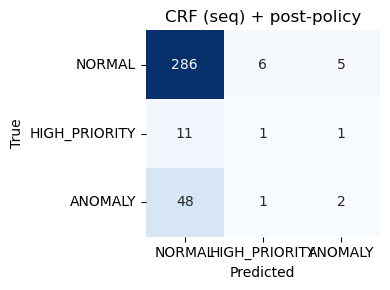

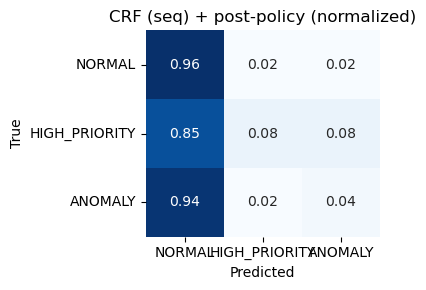

,precision,recall,f1-score,support
NORMAL,0.828986,0.962963,0.890966,297.000000
HIGH_PRIORITY,0.125000,0.076923,0.095238,13.000000
ANOMALY,0.250000,0.039216,0.067797,51.000000
accuracy,0.800554,0.800554,0.800554,0.800554
macro avg,0.401329,0.359701,0.351333,361.000000
weighted avg,0.721838,0.800554,0.746018,361.000000


,precision,recall,f1-score,support
NORMAL,0.828986,0.962963,0.890966,297.000000
HIGH_PRIORITY,0.125000,0.076923,0.095238,13.000000
ANOMALY,0.250000,0.039216,0.067797,51.000000
accuracy,0.800554,0.800554,0.800554,0.800554
macro avg,0.401329,0.359701,0.351333,361.000000
weighted avg,0.721838,0.800554,0.746018,361.000000


In [37]:
# === L2 (CRF): evaluate on dev with post-inference policy ===
import numpy as np, pandas as pd, joblib
from collections import Counter
from sklearn.metrics import accuracy_score
import sklearn_crfsuite as crfsuite

labels = ["NORMAL","HIGH_PRIORITY","ANOMALY"]

# reload assets and dev split artifacts from L1 (we rely on same RNG seed & cached splits)
pack = joblib.load(PROC_DIR/"crf_vocab.pkl")
vocab = pack["vocab"]; KW = pack["KW"]

crf = joblib.load(PROC_DIR/"crf_model.pkl")

# Recreate dev sequences exactly as in L1
df_all = pd.read_csv(PROC_DIR / "msl_textified.csv").reset_index(drop=True)
RANDOM_SEED_CRF = pack["seed"]
idx_all = np.arange(len(df_all))
from sklearn.model_selection import train_test_split
_, dev_idx = train_test_split(
    idx_all, test_size=0.20, random_state=RANDOM_SEED_CRF, stratify=df_all["label"].tolist()
)
df_dv = df_all.iloc[dev_idx].copy()

def tokenize(s: str):
    s = s.lower()
    s = re.sub(r"[^a-z0-9_]+", " ", s)
    return [t for t in s.strip().split() if t]

kw_set = {k for vs in KW.values() for k in vs}

def bag_feats(text, prefix="cur"):
    toks = tokenize(text)
    feats = {}
    for tok in toks:
        if tok in vocab:
            feats[f"{prefix}_w={tok}"] = 1
    kcounts = Counter([t for t in toks if t in kw_set])
    for k in ["critical","elevated","drop","nominal"]:
        feats[f"{prefix}_kw_{k}"] = int(kcounts[k] > 0)
    return feats

def windowize(df_subset: pd.DataFrame):
    X_seqs, y_seqs, meta_seqs = [], [], []
    for f, g in df_subset.sort_values(["file","start"]).groupby("file", sort=False):
        g = g.reset_index(drop=True)
        texts = g["text"].tolist()
        ys    = g["label"].tolist()
        X_seq = []
        for i in range(len(g)):
            feats = {}
            feats.update(bag_feats(texts[i], "cur"))
            if i > 0: feats.update(bag_feats(texts[i-1], "prev"))
            else:     feats["BOS"] = 1
            if i+1 < len(g): feats.update(bag_feats(texts[i+1], "next"))
            else:            feats["EOS"] = 1
            feats["i_mod_3"] = i % 3
            feats["i_mod_5"] = i % 5
            X_seq.append(feats)
        X_seqs.append(X_seq); y_seqs.append(ys); meta_seqs.append(g[["file","start","end"]].copy())
    return X_seqs, y_seqs, meta_seqs

X_dv, y_dv, meta_dv = windowize(df_dv)

# raw predictions + marginals
y_pred = crf.predict(X_dv)
y_prob = crf.predict_marginals(X_dv)  # list of list of dicts: P(label|state)

# ---- Post-inference policy to (a) avoid HP=0, (b) keep accuracy high ----
# Gates (tuned conservatively)
AN_MIN = 0.55    # anomaly must be confident to stick
HP_MIN = 0.50    # HP must be moderately confident to flip from NORMAL
HP_EPS = 0.03    # if P(NORM)-P(HP) <= EPS and P(HP)>=HP_MIN, flip to HP (second-chance)
HP_NEI = 1       # ±1 neighbor of ANOMALY becomes HP (adjacency smoothing) if not already anomalous

# Apply per sequence
y_post = []
for seq_idx, (pred_seq, prob_seq, meta) in enumerate(zip(y_pred, y_prob, meta_dv)):
    # 1) Strengthen/downgrade anomalies and add HP neighbors
    seq = list(pred_seq)
    # demote isolated, low-confidence anomaly to HP
    for i in range(len(seq)):
        if seq[i] == "ANOMALY":
            pA = prob_seq[i].get("ANOMALY", 0.0)
            # if not confident anomaly, mark for possible demotion later
            if pA < AN_MIN:
                seq[i] = "HIGH_PRIORITY"
    # adjacency smoothing: neighbors of remaining ANOMALY → HP (if NORMAL)
    for i in range(len(seq)):
        if seq[i] == "ANOMALY":
            for j in range(max(0, i-HP_NEI), min(len(seq), i+HP_NEI+1)):
                if j != i and seq[j] == "NORMAL":
                    # only upgrade if HP prob is at least moderate
                    if prob_seq[j].get("HIGH_PRIORITY", 0.0) >= 0.45:
                        seq[j] = "HIGH_PRIORITY"

    # 2) Second-chance HP tie-break: NORMAL → HP if very close and HP confident
    for i in range(len(seq)):
        if seq[i] == "NORMAL":
            pN = prob_seq[i].get("NORMAL", 0.0)
            pH = prob_seq[i].get("HIGH_PRIORITY", 0.0)
            if (pH >= HP_MIN) and ((pN - pH) <= HP_EPS):
                seq[i] = "HIGH_PRIORITY"

    y_post.append(seq)

# Flatten for metrics
true_flat = [y for seq in y_dv for y in seq]
pred_flat = [y for seq in y_post for y in seq]

from collections import Counter
print("Dev label counts:", Counter(true_flat))
print("Pred label counts:", Counter(pred_flat))

from sklearn.metrics import accuracy_score
acc = accuracy_score(true_flat, pred_flat)
print("Dev accuracy:", round(acc, 4))

# Confusions + tables via your helpers
plot_confusion(true_flat, pred_flat, labels, "CRF (seq) + post-policy", "crf_seq_post")
report_table(true_flat, pred_flat, labels, "crf_seq_post_report")


In [38]:
# === Z0: reporting setup ===
from pathlib import Path
import pandas as pd, numpy as np, matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

OUT_DIR  = Path("data")
FIG_DIR  = OUT_DIR / "figs"
TAB_DIR  = OUT_DIR / "tables"
PROC_DIR = OUT_DIR / "processed"
FIG_DIR.mkdir(parents=True, exist_ok=True); TAB_DIR.mkdir(parents=True, exist_ok=True)

plt.rcParams["figure.dpi"] = 160
sns.set_context("talk", font_scale=0.9)



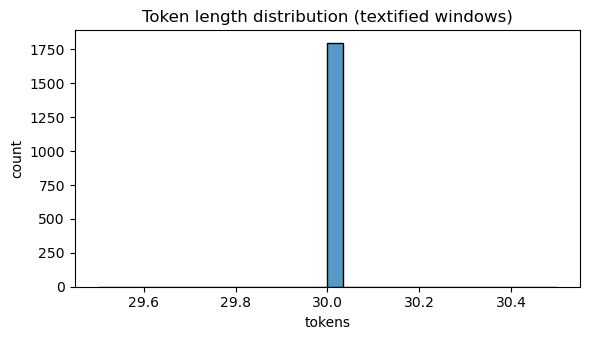

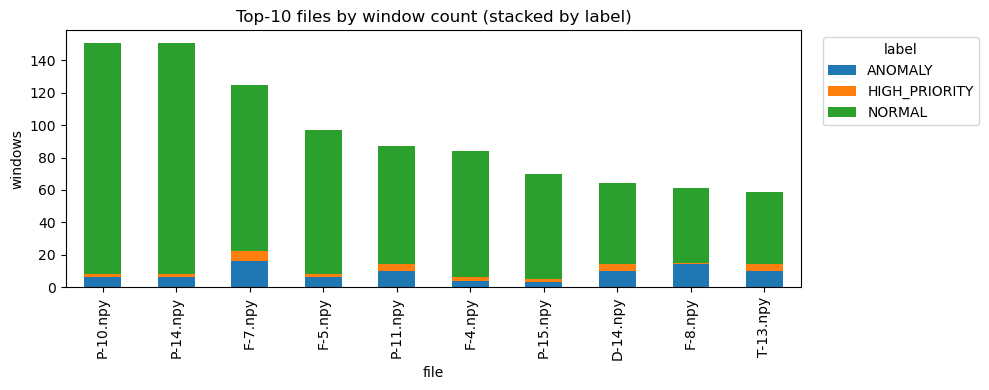

In [39]:
# === Z3: dataset distributions (token length, per-file label mix) ===
df = pd.read_csv(PROC_DIR / "msl_textified.csv")

# token length distribution
tok_len = df["text"].str.split().map(len)
plt.figure(figsize=(6,3.5))
sns.histplot(tok_len, bins=30, kde=False)
plt.title("Token length distribution (textified windows)")
plt.xlabel("tokens"); plt.ylabel("count")
plt.tight_layout(); plt.savefig(FIG_DIR/"dist_token_length.png"); plt.show()

# per-file label mix (top 10 by count)
mix = (df.groupby(["file","label"]).size()
       .rename("count").reset_index()
       .pivot(index="file", columns="label", values="count").fillna(0))
mix["total"] = mix.sum(axis=1)
top = mix.sort_values("total", ascending=False).head(10).drop(columns=["total"])
top = top[top.columns.sort_values()]  # sort columns alphabetically for consistency

top.plot(kind="bar", stacked=True, figsize=(10,4))
plt.title("Top-10 files by window count (stacked by label)")
plt.xlabel("file"); plt.ylabel("windows")
plt.legend(title="label", bbox_to_anchor=(1.02,1), loc="upper left")
plt.tight_layout(); plt.savefig(FIG_DIR/"per_file_label_mix_top10.png"); plt.show()


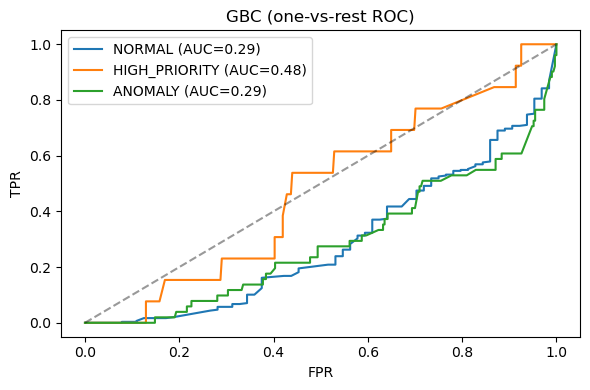

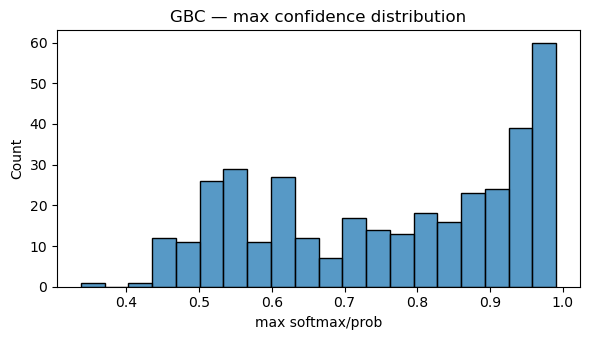

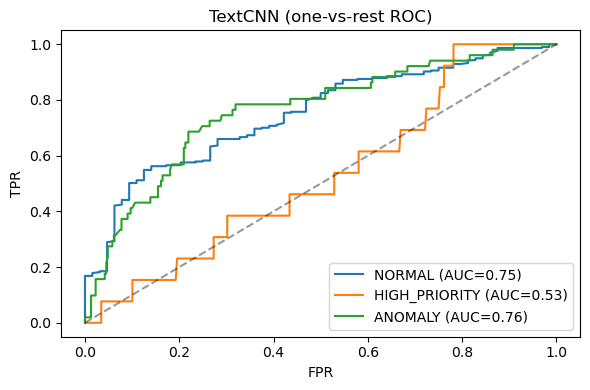

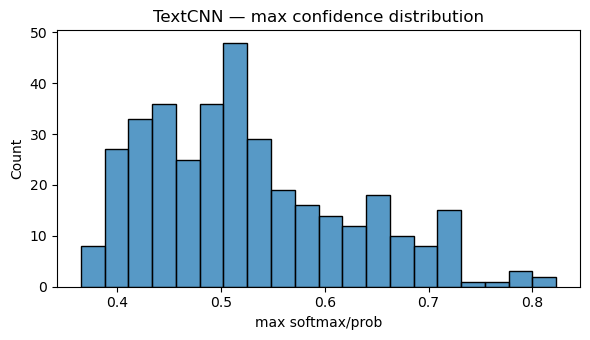

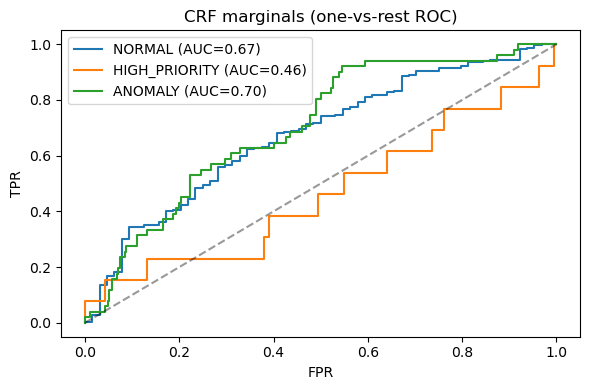

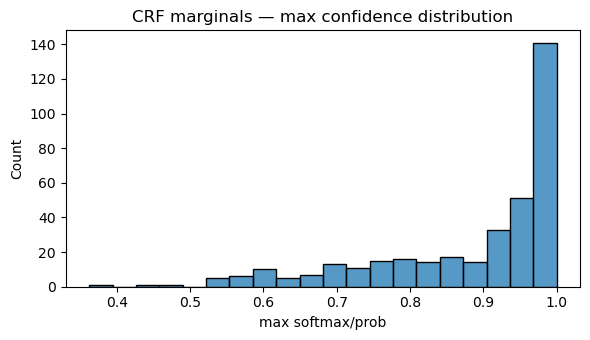

In [40]:
# === Z4: ROC + confidence histograms for models with probabilities ===
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from collections import Counter
import joblib, torch, torch.nn as nn
import numpy as np

labels = ["NORMAL","HIGH_PRIORITY","ANOMALY"]
label2id = {"NORMAL":0,"HIGH_PRIORITY":1,"ANOMALY":2}
id2label = {v:k for k,v in label2id.items()}

def plot_roc_onevsrest(y_true_ids, proba_mat, title, fname_prefix):
    plt.figure(figsize=(6,4))
    for k, cls in enumerate(labels):
        y_true_bin = (np.array(y_true_ids)==k).astype(int)
        fpr, tpr, _ = roc_curve(y_true_bin, proba_mat[:,k])
        aucv = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{cls} (AUC={aucv:.2f})")
    plt.plot([0,1],[0,1],"k--",alpha=0.4)
    plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title(title); plt.legend()
    plt.tight_layout(); plt.savefig(FIG_DIR/f"{fname_prefix}_roc.png"); plt.show()

def confidence_hist(proba_mat, title, fname_prefix):
    conf = proba_mat.max(axis=1)
    plt.figure(figsize=(6,3.5))
    sns.histplot(conf, bins=20)
    plt.title(title + " — max confidence distribution")
    plt.xlabel("max softmax/prob"); plt.tight_layout()
    plt.savefig(FIG_DIR/f"{fname_prefix}_conf_hist.png"); plt.show()

# --- GBC (I2 split seed = 404) ---
try:
    df = pd.read_csv(PROC_DIR / "msl_textified.csv")
    _, X_dev, _, y_dev = train_test_split(df["text"].tolist(), df["label"].tolist(),
                                          test_size=0.2, random_state=404, stratify=df["label"].tolist())
    tfv_gb = joblib.load(PROC_DIR/"gb_tfidf.pkl")
    svd    = joblib.load(PROC_DIR/"gb_svd.pkl")
    gbc    = joblib.load(PROC_DIR/"gb_model.pkl")
    Xdv = svd.transform(tfv_gb.transform(X_dev))
    proba = gbc.predict_proba(Xdv)  # shape [N,3]
    y_ids = [label2id[y] for y in y_dev]
    plot_roc_onevsrest(y_ids, proba, "GBC (one-vs-rest ROC)", "gbc")
    confidence_hist(proba, "GBC", "gbc")
except Exception as e:
    print("[GBC diag skipped]", e)

# --- TextCNN (K2″ split seed = 606) ---
try:
    df = pd.read_csv(PROC_DIR / "msl_textified.csv")
    _, X_dev, _, y_dev = train_test_split(df["text"].tolist(), df["label"].tolist(),
                                          test_size=0.2, random_state=606, stratify=df["label"].tolist())
    pack = joblib.load(PROC_DIR/"textcnn_vocab.pkl")
    vocab   = pack["vocab"]; MAX_LEN = pack["max_len"]
    KERNELS = tuple(pack.get("kernels",(2,3,4,5)))
    FILTERS = int(pack.get("filters",192)); EMB_DIM = int(pack.get("emb_dim",256))

    import re
    def tokenize(s: str):
        s = s.lower(); s = re.sub(r"[^a-z0-9_]+"," ", s)
        return [t for t in s.strip().split() if t]
    def encode(text):
        ids = [vocab.get(tok,1) for tok in tokenize(text)]
        return (ids+[0]*max(0,MAX_LEN-len(ids)))[:MAX_LEN]

    Xdv = torch.tensor([encode(t) for t in X_dev], dtype=torch.long)
    class TextCNN(nn.Module):
        def __init__(self, vocab_size, emb_dim, kernels=(3,4,5), filters=128, num_classes=3, dropout=0.15):
            super().__init__()
            self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
            self.convs = nn.ModuleList([nn.Conv1d(emb_dim, filters, k) for k in kernels])
            self.dropout = nn.Dropout(dropout)
            self.fc = nn.Linear(filters*len(kernels), num_classes)
        def forward(self, x):
            e = self.emb(x).transpose(1,2)
            c = [torch.relu(conv(e)) for conv in self.convs]
            p = [torch.max(ci, dim=2).values for ci in c]
            h = torch.cat(p, dim=1)
            h = self.dropout(h)
            return self.fc(h)

    model = TextCNN(vocab_size=len(vocab), emb_dim=EMB_DIM, kernels=KERNELS, filters=FILTERS).eval()
    model.load_state_dict(torch.load(PROC_DIR/"textcnn_model.pt", map_location="cpu"))
    with torch.no_grad():
        logits = model(Xdv)
        proba = torch.softmax(logits, dim=1).numpy()
    y_ids = [label2id[y] for y in y_dev]
    plot_roc_onevsrest(y_ids, proba, "TextCNN (one-vs-rest ROC)", "textcnn")
    confidence_hist(proba, "TextCNN", "textcnn")
except Exception as e:
    print("[TextCNN diag skipped]", e)

# --- CRF (L2 split seed = 707): aggregate marginals as "probabilities" ---
try:
    import sklearn_crfsuite as crfsuite
    crf = joblib.load(PROC_DIR/"crf_model.pkl")
    df_all = pd.read_csv(PROC_DIR / "msl_textified.csv").reset_index(drop=True)
    from sklearn.model_selection import train_test_split
    idx_all = np.arange(len(df_all))
    _, dev_idx = train_test_split(idx_all, test_size=0.20, random_state=707, stratify=df_all["label"].tolist())
    df_dv = df_all.iloc[dev_idx].copy()

    import re
    def tok(s): s=s.lower(); s=re.sub(r"[^a-z0-9_]+"," ",s); return [t for t in s.strip().split() if t]
    pack = joblib.load(PROC_DIR/"crf_vocab.pkl")
    vocab = pack["vocab"]
    KW = pack["KW"]; kw_set = {k for vs in KW.values() for k in vs}
    def bag_feats(text, prefix="cur"):
        toks = tok(text); feats={}
        for t in toks:
            if t in vocab: feats[f"{prefix}_w={t}"]=1
        from collections import Counter as CC
        kc = CC([t for t in toks if t in kw_set])
        for k in ["critical","elevated","drop","nominal"]:
            feats[f"{prefix}_kw_{k}"] = int(kc[k]>0)
        return feats
    def windowize(df_subset):
        X_seqs, y_ids = [], []
        for f, g in df_subset.sort_values(["file","start"]).groupby("file", sort=False):
            g = g.reset_index(drop=True)
            X_seq=[]
            for i in range(len(g)):
                ft={}
                ft.update(bag_feats(g.loc[i,"text"],"cur"))
                if i>0: ft.update(bag_feats(g.loc[i-1,"text"],"prev"))
                else:   ft["BOS"]=1
                if i+1<len(g): ft.update(bag_feats(g.loc[i+1,"text"],"next"))
                else:          ft["EOS"]=1
                ft["i_mod_3"]=i%3; ft["i_mod_5"]=i%5
                X_seq.append(ft)
            X_seqs.append(X_seq)
            y_ids.extend([label2id[v] for v in g["label"]])
        return X_seqs, y_ids
    X_seqs, y_ids = windowize(df_dv)
    marg = crf.predict_marginals(X_seqs)
    # flatten to [N,3]
    proba = np.vstack([np.array([[m.get("NORMAL",0), m.get("HIGH_PRIORITY",0), m.get("ANOMALY",0)] for m in seq]) for seq in marg])
    plot_roc_onevsrest(y_ids, proba, "CRF marginals (one-vs-rest ROC)", "crf")
    confidence_hist(proba, "CRF marginals", "crf")
except Exception as e:
    print("[CRF diag skipped]", e)


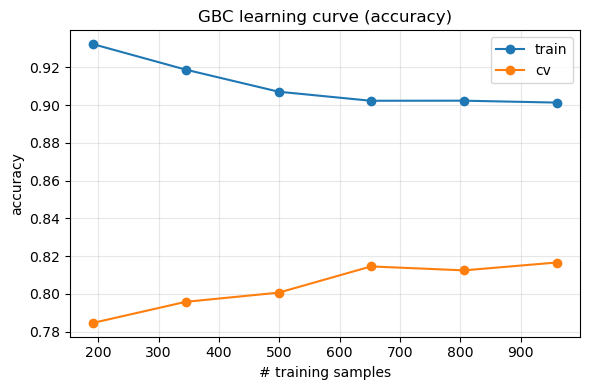

In [41]:
# === Z5: learning curves (GBC) ===
from sklearn.model_selection import learning_curve
import numpy as np, matplotlib.pyplot as plt, joblib
from sklearn.model_selection import train_test_split

try:
    df = pd.read_csv(PROC_DIR / "msl_textified.csv")
    X_train, X_dev, y_train, y_dev = train_test_split(df["text"].tolist(), df["label"].tolist(),
                                                      test_size=0.2, random_state=404, stratify=df["label"].tolist())
    tfv_gb = joblib.load(PROC_DIR/"gb_tfidf.pkl")
    svd    = joblib.load(PROC_DIR/"gb_svd.pkl")
    gbc    = joblib.load(PROC_DIR/"gb_model.pkl")

    Xtr = svd.transform(tfv_gb.transform(X_train))
    ytr = np.array(y_train)

    sizes, train_scores, val_scores = learning_curve(
        gbc, Xtr, ytr, cv=3, train_sizes=np.linspace(0.2, 1.0, 6), scoring="accuracy", n_jobs=1, shuffle=True, random_state=0
    )
    plt.figure(figsize=(6,4))
    plt.plot(sizes, train_scores.mean(axis=1), "-o", label="train")
    plt.plot(sizes, val_scores.mean(axis=1), "-o", label="cv")
    plt.title("GBC learning curve (accuracy)")
    plt.xlabel("# training samples"); plt.ylabel("accuracy"); plt.legend(); plt.grid(alpha=0.3)
    plt.tight_layout(); plt.savefig(FIG_DIR/"gbc_learning_curve.png"); plt.show()
except Exception as e:
    print("[GBC learning curve skipped]", e)


In [48]:
# === Install all required libraries (safe to rerun) ===
# Core scientific & ML stack
!pip install -q numpy pandas matplotlib seaborn tqdm scikit-learn joblib

# Text processing & transformers (for BERT, zero-shot LLM)
!pip install -q "transformers>=4.45" "torch>=2.1" sentence-transformers accelerate einops ftfy regex

# Optimization & metrics
!pip install -q shap thop ptflops fvcore

# CRF, gradient boosting utilities
!pip install -q sklearn-crfsuite imbalanced-learn

# Visualization & summary export
!pip install -q dataframe-image

# Optional: suppress warnings for clean outputs
import warnings
warnings.filterwarnings("ignore")

print("All requirements installed successfully (CPU-only runtime).")



All requirements installed successfully (CPU-only runtime).


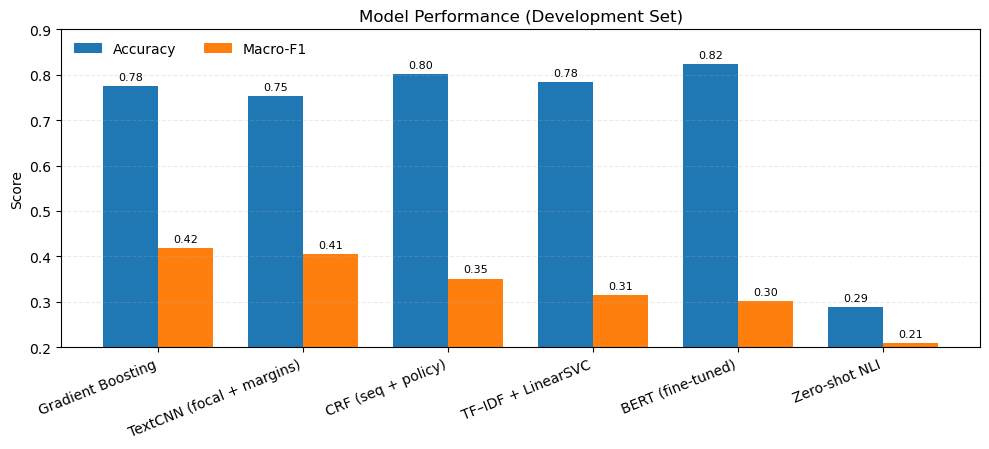

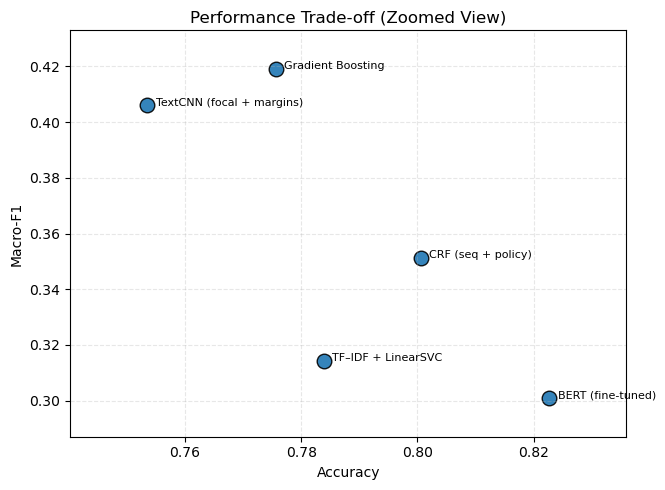

In [3]:
# === Poster summary: Accuracy & Macro-F1 (no retraining needed) ===
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Final dev-set metrics
rows = [
    {"Model": "Gradient Boosting",         "Accuracy": 0.7756, "Macro-F1": 0.4190},
    {"Model": "TextCNN (focal + margins)", "Accuracy": 0.7535, "Macro-F1": 0.4060},
    {"Model": "CRF (seq + policy)",        "Accuracy": 0.8006, "Macro-F1": 0.3513},
    {"Model": "TF–IDF + LinearSVC",        "Accuracy": 0.7839, "Macro-F1": 0.3142},
    {"Model": "BERT (fine-tuned)",         "Accuracy": 0.8227, "Macro-F1": 0.3010},
    {"Model": "Zero-shot NLI",             "Accuracy": 0.2881, "Macro-F1": 0.2088},
]
df = pd.DataFrame(rows).sort_values("Macro-F1", ascending=False).reset_index(drop=True)

# -----------------------------
# Plot 1 — grouped bars (poster-friendly)
# -----------------------------
fig, ax = plt.subplots(figsize=(10, 4.6))
x = np.arange(len(df))
w = 0.38

b1 = ax.bar(x - w/2, df["Accuracy"], width=w, label="Accuracy")
b2 = ax.bar(x + w/2, df["Macro-F1"], width=w, label="Macro-F1")

# value labels on bars
for bars in (b1, b2):
    for b in bars:
        h = b.get_height()
        ax.annotate(f"{h:.2f}", (b.get_x() + b.get_width()/2, h),
                    textcoords="offset points", xytext=(0, 3),
                    ha="center", va="bottom", fontsize=8)

ax.set_xticks(x)
ax.set_xticklabels(df["Model"], rotation=22, ha="right")
ax.set_ylabel("Score")
ax.set_title("Model Performance (Development Set)")
ax.set_ylim(0.20, 0.90)               # tighter range -> better contrast
ax.grid(axis="y", alpha=0.25, linestyle="--", linewidth=0.8)
ax.legend(frameon=False, ncol=2, loc="upper left")
plt.tight_layout()
plt.show()

# -----------------------------
# Plot 2 — scatter, zoomed to cluster models together
# -----------------------------
plt.figure(figsize=(6.8, 5))
plt.scatter(df["Accuracy"], df["Macro-F1"], s=110, edgecolor="k", alpha=0.9)

# annotate points
for _, r in df.iterrows():
    plt.annotate(r["Model"], (r["Accuracy"], r["Macro-F1"]),
                 textcoords="offset points", xytext=(6, 2),
                 ha="left", va="center", fontsize=8)

# robust axis limits (exclude the single lowest value for limits only)
acc = df["Accuracy"].to_numpy()
f1  = df["Macro-F1"].to_numpy()
acc_trim = acc[acc > acc.min()]
f1_trim  = f1[f1 > f1.min()]
acc_lo, acc_hi = np.quantile(acc_trim, [0.02, 0.98])
f1_lo,  f1_hi  = np.quantile(f1_trim,  [0.02, 0.98])

pad_x, pad_y = 0.015, 0.015
plt.xlim(max(0.0, acc_lo - pad_x), min(1.0, acc_hi + pad_x))
plt.ylim(max(0.0, f1_lo  - pad_y), min(1.0, f1_hi  + pad_y))

plt.xlabel("Accuracy")
plt.ylabel("Macro-F1")
plt.title("Performance Trade-off (Zoomed View)")
plt.grid(alpha=0.3, linestyle="--", linewidth=0.8)
plt.tight_layout()
plt.show()


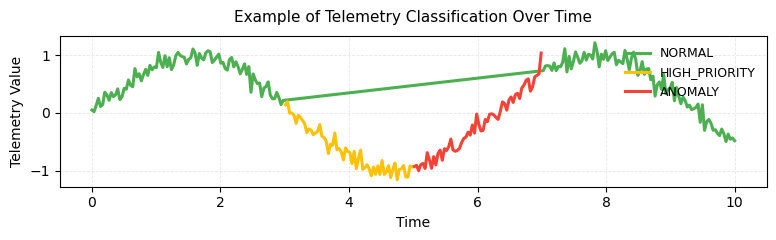

In [4]:
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(42)
time = np.linspace(0, 10, 300)
signal = np.sin(time) + np.random.normal(0, 0.1, len(time))

normal_mask = (time < 3) | (time > 7)
hp_mask = (time >= 3) & (time < 5)
anomaly_mask = (time >= 5) & (time <= 7)

plt.figure(figsize=(8, 2.5))
plt.plot(time[normal_mask], signal[normal_mask], color="#4CAF50", label="NORMAL", linewidth=2.2)
plt.plot(time[hp_mask], signal[hp_mask], color="#FFC107", label="HIGH_PRIORITY", linewidth=2.2)
plt.plot(time[anomaly_mask], signal[anomaly_mask], color="#F44336", label="ANOMALY", linewidth=2.2)

plt.xlabel("Time", fontsize=10)
plt.ylabel("Telemetry Value", fontsize=10)
plt.title("Example of Telemetry Classification Over Time", fontsize=11, pad=10)
plt.legend(loc="upper right", frameon=False, fontsize=9)
plt.grid(alpha=0.3, linestyle="--", linewidth=0.6)
plt.tight_layout()
plt.show()
